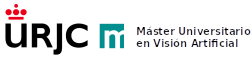

                                                                                      Práctica III: Imagen Médica
                                                                                      Diego González Oviaño
                                                                                      Paula Pena González

# Uncertainty Quantification in DL for Medical Imaging

**Uncertainty Quantification** (UQ) pretends to give an estimate on the confidence of the prediction given by a certain DL method, giving, therefore a tool to better interpret the results obtained.

An algorithm’s uncertainty is associated to two factors: (1) data variability (usually referred as
*aleatoric uncertainty*); and (2) the election of the model’s parameters (*epistemic uncertainty*). Quantifying this uncertainty will be essential to ensure the reliability of the model.

In this practical session, we will explore two fundamental methods for quantifying uncertainty in deep learning models: **ensembles** for the estimation of *epistemic uncertainty* and **test-time augmentation** (TTA) for capturing *aleatoric uncertainty*.

> - [Norberto Malpica](mailto:norberto.malpica@urjc.es)
> - [Blanca Rodríguez González](mailto:blanca.rodriguez@urjc.es)

## Fisrt Steps... Getting to know the problem

Skin cancer is a major public health problem, with over 20000 newly diagnosed cases in Spain just in 2023. Spain has one of Europe's lowest melanoma incidence and mortality rates. Nevertheless, it is one of the fastest-growing pathologies in our country, with a 181.3 % increase in the incidence rate in men and 205.3 % increase in women.

Early diagnosis of this condition is crucial, as it significantly improves survival rates, allowing for appropiate medical management and reducing the likelihood of metastasis. One of the most effective tools for early melanoma detection is **dermoscopy**, a non-invasive imaging technique that helpson the visualization of skin lesions, improving the ability to differentiate between benign and malignant abnormalities. However, dermoscopic image interpretation requires significant expertise.

To address these challenges, automated analysis methods have gained increasing attention in recent years. Among them, **lesion segmentation** is a fundamental step in computer-aided diagnosis, as it enables the precise identification and delineation of suspicious skin lesions from surrounding healthy tissue. Accurate segmentation not only facilitates the extraction of clinically relevant features but also enhances the performance of deep learning models trained for lesion classification. By integrating advanced segmentation techniques into diagnostic workflows, artificial intelligence can support dermatologists in achieving more consistent and reliable evaluations, ultimately improving patient outcomes and optimizing healthcare resources.

**`The ISIC Challenge`**

The *International Skin Imaging Collaboration* (ISIC) *Challenge* is a globally recognized initiative aimed at advancing the automated analysis of skin lesions through artificial intelligence. The challenge is built upon the [**ISIC Archive**](https://challenge.isic-archive.com/), the largest publicly available repository of dermoscopic images, contributed by leading dermatology centers worldwide. These images include expert-annotated segmentations and diagnostic labels, making the dataset highly valuable for the development and validation of computer vision models.

<div class="alert alert-block alert-info">
The main objective of this practical session is to explore uncertainty quantification in deep learning models applied to skin lesion segmentation.
</div>

Two specific tasks are proposed in this project:

1. Quantifying Epistemic Uncertainy through simple ensemble methods
2. EStimating Aleatoric Uncertainty through Test-Time Augmentation 

Through this practical session, you will learn how to implement these techniques, generate uncertainty maps, and visualize the confidence levels of the model’s predictions, ultimately improving interpretability and reliability in automated skin lesion analysis.


## `TASK 0`: Understanding and preparing the data set 


Together with this Jupyter Notebook, you will find the [ISIC 2016 Challenge Data](https://challenge.isic-archive.com/landing/2016/) for the lesion segmentation task. The dataset is divided into train and test sets, each containing a folder for the dermoscopic images and another for the corresponding ground truth masks, paired using the same identifier.

In this first section,images should be visualized to gain a better understanding of the dataset, examining both the dermoscopic images and their corresponding ground truth masks. This step is essential for identifying potential challenges, such as variations in lighting, contrast, or artifacts that could impact model performance.

Following visualization, students will apply preprocessing techniques to ensure the quality and consistency of the input data. This may include dataset slitting, resampling or normalization, among oters. By carefully selecting and implementing these preprocessing steps, students will optimize the dataset for training and evaluation, laying a solid foundation for subsequent uncertainty quantification and segmentation tasks.

In [32]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
from pandas.core.common import random_state
%matplotlib inline

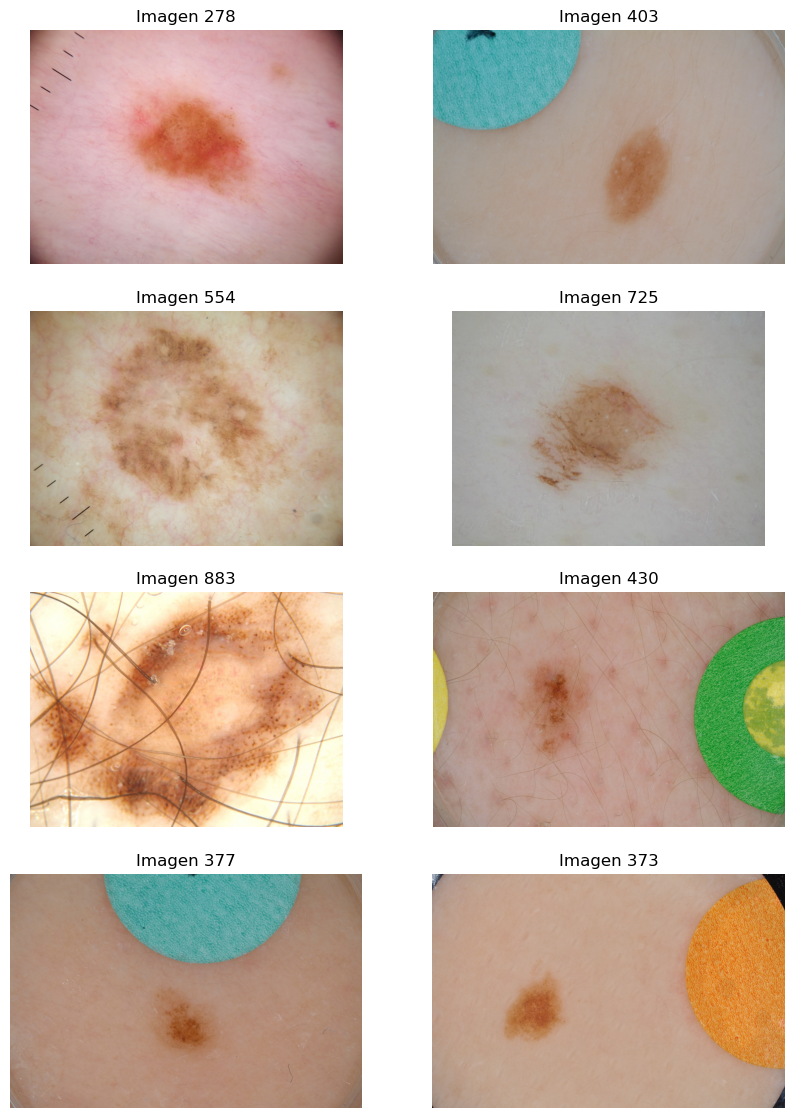

In [22]:
imagesTR_path = './DATA-LesionSegmentation/train/ImagesTr'
labelsTR_path = './DATA-LesionSegmentation/train/LabelsTr'

imagesTS_path = './DATA-LesionSegmentation/test/ImagesTs'
labelsTS_path = './DATA-LesionSegmentation/test/LabelsTs'

# 1. Load images
lst_img = os.listdir(imagesTR_path)
random.seed(80)
random_imgs = random.sample(range(len(lst_img)), 8)

fig, axs = plt.subplots(len(random_imgs)//2, 2, figsize = (10, 14))
for i, idx in enumerate(random_imgs):
    row = i // 2
    col = i % 2

    img = cv2.imread(os.path.join(imagesTR_path, lst_img[idx]))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axs[row, col].imshow(img_rgb)
    axs[row, col].set_title(f"Imagen {idx}")
    axs[row, col].axis('off')

plt.show()
fig.tight_layout()


Tras una elección de 8 imágenes aleatorias del conjunto de train se puede observar la existencia de variabilidad en dicho conjunto. Se observa pieles más claras, más oscuras, imágenes con distinta iluminación, con distinta resolución, sujetos sin depilar, depilados y, en ciertas imágenes, presencia de objetos externos.

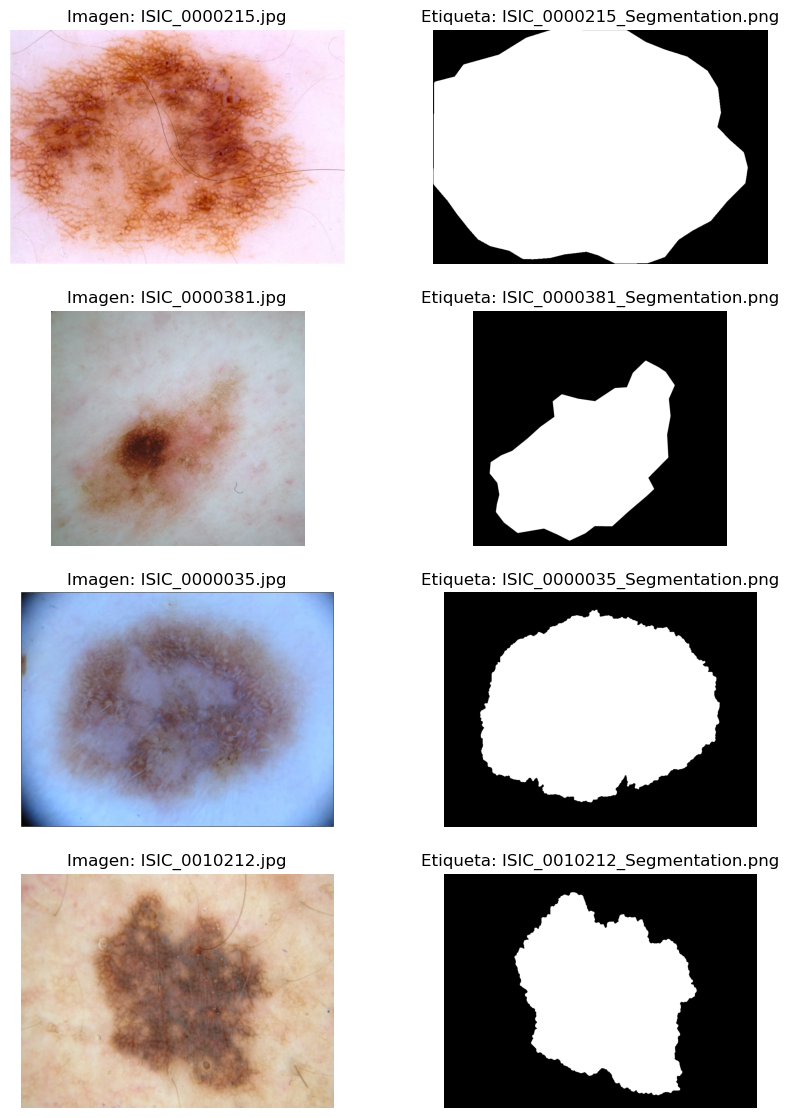

In [23]:
# 2. Visualize some image-segmentation pairs
random.seed(22)
random_imgs = random.sample(range(len(lst_img)), 4)
lst_label = os.listdir(labelsTR_path)

fig, axs = plt.subplots(len(random_imgs), 2, figsize = (10, 14))

for i, idx in enumerate(random_imgs):
    img = cv2.imread(os.path.join(imagesTR_path, lst_img[idx]))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_label = cv2.imread(os.path.join(labelsTR_path, lst_label[idx]), 0)

    axs[i, 0].imshow(img_rgb)
    axs[i, 0].set_title(f"Imagen: {lst_img[idx]}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(img_label, cmap='gray')
    axs[i, 1].set_title(f"Etiqueta: {lst_label[idx]}")
    axs[i, 1].axis('off')

plt.show()
fig.tight_layout()




In [2]:
# Resolución de imágenes

imagesTR_path = './DATA-LesionSegmentation/train/ImagesTr'
labelsTR_path = './DATA-LesionSegmentation/train/LabelsTr'

lst_img = os.listdir(imagesTR_path)
resolution = []
for idx in lst_img:
    img = cv2.imread(os.path.join(imagesTR_path, idx))
    r = img.shape[1], img.shape[0]
    resolution.append(r)

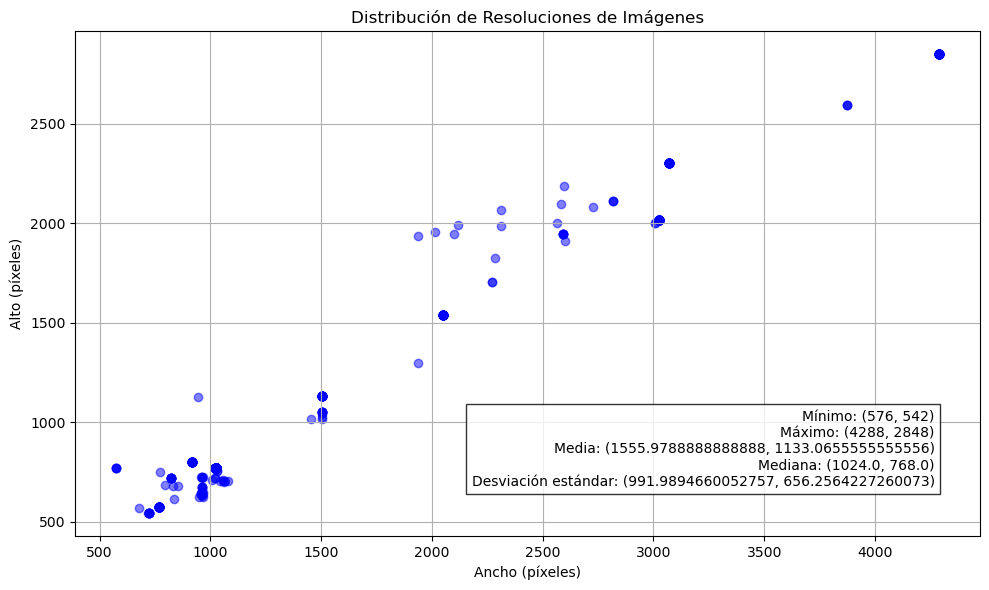

In [3]:
# Separar anchos y altos
widths = [r[0] for r in resolution]
heights = [r[1] for r in resolution]

# Crear figura
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5, c='blue')
plt.title('Distribución de Resoluciones de Imágenes')
plt.xlabel('Ancho (píxeles)')
plt.ylabel('Alto (píxeles)')
plt.grid(True)

stats = {
    'Mínimo': (min(widths), min(heights)),
    'Máximo': (max(widths), max(heights)),
    'Media': (np.mean(widths), np.mean(heights)),
    'Mediana': (np.median(widths), np.median(heights)),
    'Desviación estándar': (np.std(widths), np.std(heights))
}

stats_text = "\n".join([f"{k}: {v}" for k, v in stats.items()])
plt.gca().text(0.95, 0.25, stats_text, transform=plt.gca().transAxes,
              verticalalignment='top', horizontalalignment='right',
              bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Se observa que los datos de resolución del conjunto son muy variados, por tanto, para no introducir ruido al modelo, se estandarizará dicha resolución atendiendo a la media.

Imágenes con un alto + ancho mayor de 2500: 51
ISIC_0001184.jpg
ISIC_0001187.jpg
ISIC_0001188.jpg
ISIC_0001191.jpg
ISIC_0001212.jpg
ISIC_0001213.jpg
ISIC_0001216.jpg
ISIC_0002616.jpg
ISIC_0002647.jpg
ISIC_0002780.jpg
ISIC_0002806.jpg
ISIC_0002836.jpg
ISIC_0002885.jpg
ISIC_0002975.jpg
ISIC_0002976.jpg
ISIC_0003051.jpg
ISIC_0003346.jpg
ISIC_0004166.jpg
ISIC_0004168.jpg
ISIC_0004309.jpg
ISIC_0004985.jpg
ISIC_0006021.jpg
ISIC_0006612.jpg
ISIC_0006795.jpg
ISIC_0006940.jpg
ISIC_0007038.jpg
ISIC_0007788.jpg
ISIC_0008029.jpg
ISIC_0008145.jpg
ISIC_0008236.jpg
ISIC_0008256.jpg
ISIC_0008347.jpg
ISIC_0008396.jpg
ISIC_0008524.jpg
ISIC_0008528.jpg
ISIC_0008541.jpg
ISIC_0008552.jpg
ISIC_0008807.jpg
ISIC_0008879.jpg
ISIC_0008913.jpg
ISIC_0009165.jpg
ISIC_0009188.jpg
ISIC_0009297.jpg
ISIC_0009344.jpg
ISIC_0009504.jpg
ISIC_0009505.jpg
ISIC_0009533.jpg
ISIC_0009583.jpg
ISIC_0009599.jpg
ISIC_0009800.jpg
ISIC_0009860.jpg


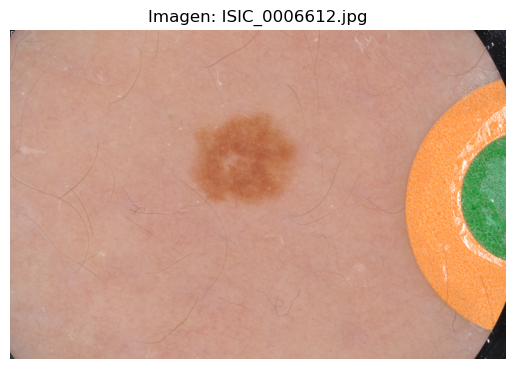

In [4]:
# Se visualiza cuántos son outliers para ver si se puede recortar la imagen para reducir resolución
high_idx = [i for i, (w, h) in enumerate(resolution) if (w + h) > 7000]
print(f"Imágenes con un alto + ancho mayor de 2500: {len(high_idx)}")
for idx in high_idx:
    print(lst_img[idx])


img = cv2.imread(os.path.join(imagesTR_path, lst_img[high_idx[22]]))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Imagen: {lst_img[high_idx[22]]}")
plt.show()


Para reducir dimensión y no perder detalle se puede recortar la región de interés. Para ello se guardan las imágenes en subcarpetas según su resolución.

In [21]:
os.makedirs('Newmodel', exist_ok=True)
os.makedirs('Newmodel/train', exist_ok=True)
os.makedirs('Newmodel/train/ImagesTr', exist_ok=True)
os.makedirs('Newmodel/train/LabelsTr', exist_ok=True)

In [19]:
imagesTR_path = './DATA-LesionSegmentation/train/ImagesTr'
labelsTR_path = './DATA-LesionSegmentation/train/LabelsTr'

out_images_path = './Newmodel/train/ImagesTr'
out_labels_path = './Newmodel/train/LabelsTr'

lst_img = os.listdir(imagesTR_path)

for filename in lst_img:
    # Leer la imagen
    img_path = os.path.join(imagesTR_path, filename)
    img = cv2.imread(img_path)
    label_path = os.path.join(labelsTR_path, str(filename.split('.')[0] + '_Segmentation.png'))
    label_img = cv2.imread(label_path)
    height, width = img.shape[:2]

    # Nombre carpeta
    res_folder = f"{width}x{height}"
    out_dir = os.path.join(out_images_path, res_folder)
    out_dir_label = os.path.join(out_labels_path, res_folder)

    # Crear carpeta
    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(out_dir_label, exist_ok=True)

    # Guardar imagen en la carpeta correspondiente
    dest_path = os.path.join(out_dir, filename)
    dest_label_path = os.path.join(out_dir_label, filename)
    cv2.imwrite(dest_path, img)
    cv2.imwrite(dest_label_path, label_img)


In [41]:
# recortamos con tamaño 1024x768 (media) las imágenes de mayor resolución
os.makedirs('Newmodel_res', exist_ok=True)
os.makedirs('Newmodel_res/train', exist_ok=True)
os.makedirs('Newmodel_res/train/ImagesTr', exist_ok=True)
os.makedirs('Newmodel_res/train/LabelsTr', exist_ok=True)
large_images_path = './Newmodel_res/train/ImagesTr/'

In [42]:
def crop_black_white_borders(img_rgb, label_mak):
    kernel = np.ones((5,5),np.uint8)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    _, mask_white = cv2.threshold(img_gray, 243, 255, cv2.THRESH_BINARY_INV)
    _, mask_black = cv2.threshold(img_gray, 7, 255, cv2.THRESH_BINARY)
    mask = cv2.bitwise_and(mask_white, mask_black)
    mask = cv2.erode(mask,kernel,iterations = 3)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(contours, key=cv2.contourArea)
    x2, y2, w2, h2 = cv2.boundingRect(c)

    img = img_rgb[y2:y2+h2, x2:x2+w2]
    label_img = label_mak[y2:y2+h2, x2:x2+w2]

    return img, label_img


In [43]:
# 3. Preprocess your data!
imagesTR_path = './DATA-LesionSegmentation/train/ImagesTr'
labelsTR_path = './DATA-LesionSegmentation/train/LabelsTr'

out_images_path = './Newmodel_res/train/ImagesTr'
out_labels_path = './Newmodel_res/train/LabelsTr'

lst_img = os.listdir(imagesTR_path)
images = [i for i in lst_img if i == 'ISIC_0000185.jpg']

target_res = (768, 1024)  # (height, width), media

for filename in lst_img:
    print(filename)
    img_path = os.path.join(imagesTR_path, filename)
    base_name = os.path.splitext(filename)[0]
    label_path = os.path.join(labelsTR_path, f"{base_name}_Segmentation.png")

    img = cv2.imread(img_path)
    label_img = cv2.imread(label_path, 0)
    img, label_img = crop_black_white_borders(img, label_img)

    height, width = img.shape[:2]

    contours, _ = cv2.findContours(label_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, roi_w, roi_h = cv2.boundingRect(largest_contour)
    margin = int(max(roi_w, roi_h) * 0.05)  # Margen del 5%

    x1, y1 = max(0, x - margin), max(0, y - margin)
    x2, y2 = min(width, x + roi_w + margin), min(height, y + roi_h + margin)
    target_h, target_w = target_res

    # Caso 1 ROI más pequeña que resolución final, puedo recortar
    roi_w, roi_h = x2 - x1, y2 - y1
    if roi_w <= target_w and roi_h <= target_h and width >= target_w and height >= target_h:
        print('Recortar ROI', filename)
        cy = y1 + roi_h // 2
        cx = x1 + roi_w // 2

        start_y = max(0, min(cy - target_h//2, height - target_h))
        start_x = max(0, min(cx - target_w//2, width  - target_w))

        end_y = start_y + target_h
        end_x = start_x + target_w

        img   = img[start_y:end_y, start_x:end_x]
        label = label_img[start_y:end_y, start_x:end_x]

        height, width = img.shape[:2]
        print(height, width)

    else: # Imágen más grande o más pequeña, hacer interpolación
        print('Interpolación', filename)
        scale = min(target_w/width, target_h/height)
        new_w, new_h = int(width*scale), int(height*scale)

        img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)
        label_img = cv2.resize(label_img, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        # Cuánto hay que padd en cada lado
        pad_w1 = (target_w - new_w) // 2
        pad_h1 = (target_h - new_h) // 2
        pad_w2 = target_w - new_w - pad_w1
        pad_h2 = target_h - new_h - pad_h1

        img = cv2.copyMakeBorder(img, top=pad_h1, bottom=pad_h2, left=pad_w1,
                             right=pad_w2, borderType=cv2.BORDER_REPLICATE)

        label_img = cv2.copyMakeBorder(label_img, top=pad_h1, bottom=pad_h2, left=pad_w1, right=pad_w2,borderType=cv2.BORDER_CONSTANT, value=0 )
        #cv2.imshow(base_name, img)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()

        height, width = img.shape[:2]

    # Guardar imagen
    dest_path = os.path.join(out_images_path, filename)
    dest_label_path = os.path.join(out_labels_path, filename)
    cv2.imwrite(dest_path, img)
    cv2.imwrite(dest_label_path, label)



ISIC_0000000.jpg
Interpolación ISIC_0000000.jpg
ISIC_0000001.jpg
Interpolación ISIC_0000001.jpg
ISIC_0000002.jpg
Interpolación ISIC_0000002.jpg
ISIC_0000004.jpg
Interpolación ISIC_0000004.jpg
ISIC_0000006.jpg
Interpolación ISIC_0000006.jpg
ISIC_0000007.jpg
Interpolación ISIC_0000007.jpg
ISIC_0000008.jpg
Interpolación ISIC_0000008.jpg
ISIC_0000009.jpg
Interpolación ISIC_0000009.jpg
ISIC_0000010.jpg
Interpolación ISIC_0000010.jpg
ISIC_0000011.jpg
Interpolación ISIC_0000011.jpg
ISIC_0000016.jpg
Interpolación ISIC_0000016.jpg
ISIC_0000017.jpg
Recortar ROI ISIC_0000017.jpg
768 1024
ISIC_0000018.jpg
Interpolación ISIC_0000018.jpg
ISIC_0000019.jpg
Interpolación ISIC_0000019.jpg
ISIC_0000021.jpg
Interpolación ISIC_0000021.jpg
ISIC_0000024.jpg
Interpolación ISIC_0000024.jpg
ISIC_0000025.jpg
Interpolación ISIC_0000025.jpg
ISIC_0000026.jpg
Interpolación ISIC_0000026.jpg
ISIC_0000028.jpg
Recortar ROI ISIC_0000028.jpg
768 1024
ISIC_0000029.jpg
Interpolación ISIC_0000029.jpg
ISIC_0000030.jpg
Interpo

In [ ]:
# Para el test se puede hacer un resize con interpolación al no contar con la información de la máscara segmentada y un crop de los bordes como se ha indicado.

In [44]:
# Nuevo dataset preprocesado
# Resolución de imágenes

imagesTR_path = './Newmodel_res/train/ImagesTr'
labelsTR_path = './Newmodel_res/train/LabelsTr'

lst_img = os.listdir(imagesTR_path)
label_list = os.listdir(labelsTR_path)
resolution = []
resolution_label = []
for idx in lst_img:
    img = cv2.imread(os.path.join(imagesTR_path, idx))
    r = img.shape[1], img.shape[0]
    resolution.append(r)
for idx in label_list:
    label = cv2.imread(os.path.join(labelsTR_path, idx))
    r = label.shape[1], label.shape[0]
    resolution_label.append(r)

print(np.unique(resolution))
print(np.unique(resolution_label))

[ 768 1024]
[ 768 1024]


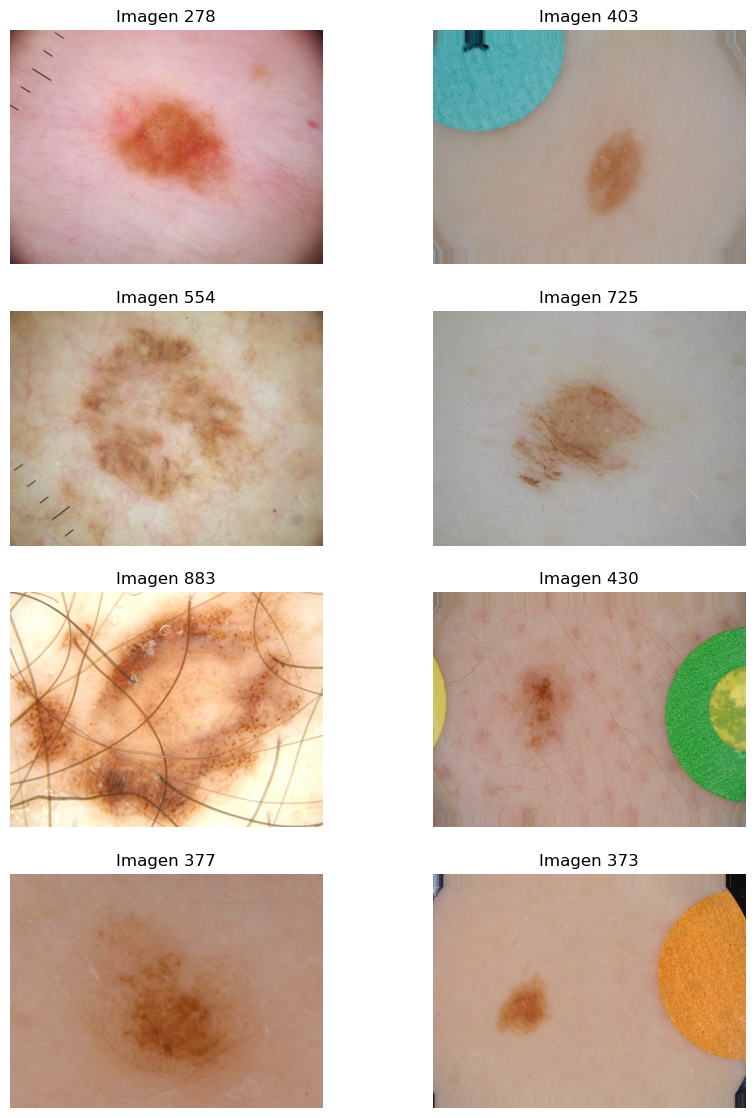

In [92]:
imagesTR_path = './Newmodel_res/train/ImagesTr'
labelsTR_path = './Newmodel_res/train/LabelsTr'

imagesTS_path = './Newmodel_res/test/ImagesTs'
labelsTS_path = './Newmodel_res/test/LabelsTs'

# 1. Load images
lst_img = os.listdir(imagesTR_path)
random.seed(80)
random_imgs = random.sample(range(len(lst_img)), 8)

fig, axs = plt.subplots(len(random_imgs)//2, 2, figsize = (10, 14))
for i, idx in enumerate(random_imgs):
    row = i // 2
    col = i % 2

    img = cv2.imread(os.path.join(imagesTR_path, lst_img[idx]))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axs[row, col].imshow(img_rgb)
    axs[row, col].set_title(f"Imagen {idx}")
    axs[row, col].axis('off')

plt.show()
fig.tight_layout()


## `TASK 1`: Quantifying epistemic uncertainty with deep ensembles

Epistemic uncertainty – from Ancient Greek *ϵπιστημη* meaning knowledge – refers to the uncertainty arising from a lack of knowledge or statistical evidence. A common approach to model epistemic uncertainty is the use of **deep ensembles**. This method involves training $N$ neural networks independently, each with different random initializations. At inference time, the variability across the predictions of these models reflects the epistemic uncertainty: if all models agree, the epistemic uncertainty is low; if their predictions diverge, it indicates high uncertainty about the outcome. Evaluating this variability is essential.

Once your data is preprocessed, train an ensemble of $N$ similar models with different random initialization seeds and evaluate them traditionally using 'standard' metrics like **Dice Coefficient**. Random initialization seed can control data sampling, stochastic optimization algorithms, and other processes during training. In the end, you will get $N$ models trained on the same data, but converging to different local minima

> **`NOTE`**: Don't focuss on getting the best results!! We are not looking for that :)


In [53]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import Dataset
import torch.optim as optim
from tqdm import tqdm
import gc
import random
import numpy as np
import os
from torchvision.transforms.functional import to_tensor

# 1. Define baseline segmentation model using your favourite library (Keras, Pytorch)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), # Convolución 2d
            nn.ReLU(inplace=True) # Función de activación
        )

    def forward(self, x):
        return self.block(x)

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder1 = ConvBlock(3, 32) # 64 filtros
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = ConvBlock(32, 64) # 128
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck1 = ConvBlock(64, 128) # 256

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # 128
        self.decoder2 = ConvBlock(128, 64)

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) # 64
        self.decoder1 = ConvBlock(64, 32)

        self.final_conv  = nn.Conv2d(32, 1, kernel_size=1) # 1

    def forward(self, x):
        # encoder
        e1 = self.encoder1(x)
        p1 = self.pool1(e1)

        e2 = self.encoder2(p1)
        p2 = self.pool2(e2)

        # bottleneck
        b = self.bottleneck1(p2)

        # decoder
        up2 = self.upconv2(b)
        cat2 = torch.cat([up2, e2], 1) # concatenar
        d2 = self.decoder2(cat2)

        up1 = self.upconv1(d2)
        cat1 = torch.cat([up1, e1], 1)
        d1 = self.decoder1(cat1)

        return torch.sigmoid(self.final_conv (d1)) # salida sigmoide




In [72]:
class SkinLesionDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_names = sorted(os.listdir(images_dir))
        self.mask_names = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_names[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_names[idx])

        # Carga la imagen y la máscara tal cual (sin cambios)
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Escala de grises

        # Convierte a tensor manualmente (sin normalizar ni redimensionar)
        image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.
        mask = torch.from_numpy(np.array(mask)).unsqueeze(0).float() / 255.

        return image, mask

In [73]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

Sat May 10 21:49:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.60                 Driver Version: 572.60         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8              2W /   66W |     217MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

dataset = SkinLesionDataset(
    images_dir="./Newmodel_res/train/ImagesTr",
    masks_dir="./Newmodel_res/train/LabelsTr",
)

train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)

from PIL import UnidentifiedImageError

for i in range(len(dataset)):
    try:
        image, mask = dataset[i]
        if image.shape[-2:] != (768, 1024) or mask.shape[-2:] != (768, 1024):
            print(f"[{i}] Tamaño incorrecto: {image.shape} | {mask.shape}")
    except UnidentifiedImageError as e:
        print(f"[{i}] Archivo corrupto: {dataset.image_names[i]} o {dataset.mask_names[i]}")
    except Exception as e:
        print(f"[{i}] Error inesperado: {e}")

Usando: cuda


In [75]:
# Train model 1
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

model_1 = SimpleUNet().to(device)

criterion = nn.BCELoss()  # Segmentación
optimizer = optim.Adam(model_1.parameters(), lr=1e-4)

from tqdm import tqdm

num_epochs = 5

for epoch in range(num_epochs):
    model_1.train()
    epoch_loss = 0
    epoch_dice = 0

    for images, masks in tqdm(train_loader, desc=f"Modelo con semilla {seed} - Época {epoch+1}"):
        images = images.to(device)
        masks = masks.to(device)

        preds = model_1(images)  # [B, 1, H, W]
        loss = criterion(preds, masks.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Época {epoch+1} | Pérdida: {epoch_loss / len(train_loader):.4f}")

# Guardar modelo
torch.save(model_1.state_dict(), "model_1.pth")

Modelo con semilla 42 - Época 1: 100%|██████████| 225/225 [01:25<00:00,  2.63it/s]


Época 1 | Pérdida: 0.6188


Modelo con semilla 42 - Época 2: 100%|██████████| 225/225 [01:24<00:00,  2.67it/s]


Época 2 | Pérdida: 0.5470


Modelo con semilla 42 - Época 3: 100%|██████████| 225/225 [01:27<00:00,  2.58it/s]


Época 3 | Pérdida: 0.5294


Modelo con semilla 42 - Época 4: 100%|██████████| 225/225 [01:25<00:00,  2.64it/s]


Época 4 | Pérdida: 0.5249


Modelo con semilla 42 - Época 5: 100%|██████████| 225/225 [01:27<00:00,  2.57it/s]

Época 5 | Pérdida: 0.5200


In [76]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

In [77]:
# Train model 2
seed = 7
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

model_2 = SimpleUNet().to(device)

criterion = nn.BCELoss()  # Segmentación
optimizer = optim.Adam(model_2.parameters(), lr=1e-4)

from tqdm import tqdm

num_epochs = 5

for epoch in range(num_epochs):
    model_2.train()
    epoch_loss = 0
    epoch_dice = 0

    for images, masks in tqdm(train_loader, desc=f"Modelo con semilla {seed} - Época {epoch+1}"):
        images = images.to(device)
        masks = masks.to(device)

        preds = model_2(images)  # [B, 1, H, W]
        loss = criterion(preds, masks.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Época {epoch+1} | Pérdida: {epoch_loss / len(train_loader):.4f}")

# Guardar modelo
torch.save(model_2.state_dict(), "model_2.pth")


Modelo con semilla 7 - Época 1: 100%|██████████| 225/225 [01:24<00:00,  2.67it/s]


Época 1 | Pérdida: 0.6255


Modelo con semilla 7 - Época 2: 100%|██████████| 225/225 [01:42<00:00,  2.19it/s]


Época 2 | Pérdida: 0.5451


Modelo con semilla 7 - Época 3: 100%|██████████| 225/225 [01:51<00:00,  2.01it/s]


Época 3 | Pérdida: 0.5354


Modelo con semilla 7 - Época 4: 100%|██████████| 225/225 [01:52<00:00,  2.01it/s]


Época 4 | Pérdida: 0.5229


Modelo con semilla 7 - Época 5: 100%|██████████| 225/225 [01:52<00:00,  2.00it/s]

Época 5 | Pérdida: 0.5205


In [78]:
# Train model 3
seed = 22
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

model_3 = SimpleUNet().to(device)

criterion = nn.BCELoss()  # Segmentación
optimizer = optim.Adam(model_3.parameters(), lr=1e-4)

from tqdm import tqdm

num_epochs = 5

for epoch in range(num_epochs):
    model_3.train()
    epoch_loss = 0
    epoch_dice = 0

    for images, masks in tqdm(train_loader, desc=f"Modelo con semilla {seed} - Época {epoch+1}"):
        images = images.to(device)
        masks = masks.to(device)

        preds = model_3(images)  # [B, 1, H, W]
        loss = criterion(preds, masks.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Época {epoch+1} | Pérdida: {epoch_loss / len(train_loader):.4f}")

# Guardar modelo
torch.save(model_3.state_dict(), "model_3.pth")


Modelo con semilla 22 - Época 1: 100%|██████████| 225/225 [01:50<00:00,  2.04it/s]


Época 1 | Pérdida: 0.5960


Modelo con semilla 22 - Época 2: 100%|██████████| 225/225 [01:31<00:00,  2.45it/s]


Época 2 | Pérdida: 0.5452


Modelo con semilla 22 - Época 3: 100%|██████████| 225/225 [01:24<00:00,  2.65it/s]


Época 3 | Pérdida: 0.5322


Modelo con semilla 22 - Época 4: 100%|██████████| 225/225 [01:24<00:00,  2.67it/s]


Época 4 | Pérdida: 0.5298


Modelo con semilla 22 - Época 5: 100%|██████████| 225/225 [01:24<00:00,  2.67it/s]

Época 5 | Pérdida: 0.5274


In [79]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

In [80]:
# Train model 4
seed = 13
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

model_4 = SimpleUNet().to(device)

criterion = nn.BCELoss()  # Segmentación
optimizer = optim.Adam(model_4.parameters(), lr=1e-4)

from tqdm import tqdm

num_epochs = 5

for epoch in range(num_epochs):
    model_4.train()
    epoch_loss = 0
    epoch_dice = 0

    for images, masks in tqdm(train_loader, desc=f"Modelo con semilla {seed} - Época {epoch+1}"):
        images = images.to(device)
        masks = masks.to(device)

        preds = model_4(images)  # [B, 1, H, W]
        loss = criterion(preds, masks.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Época {epoch+1} | Pérdida: {epoch_loss / len(train_loader):.4f}")

# Guardar modelo
torch.save(model_4.state_dict(), "model_4.pth")


Modelo con semilla 13 - Época 1: 100%|██████████| 225/225 [01:50<00:00,  2.04it/s]


Época 1 | Pérdida: 0.6243


Modelo con semilla 13 - Época 2: 100%|██████████| 225/225 [01:46<00:00,  2.11it/s]


Época 2 | Pérdida: 0.5446


Modelo con semilla 13 - Época 3: 100%|██████████| 225/225 [01:41<00:00,  2.23it/s]


Época 3 | Pérdida: 0.5354


Modelo con semilla 13 - Época 4: 100%|██████████| 225/225 [01:52<00:00,  2.00it/s]


Época 4 | Pérdida: 0.5325


Modelo con semilla 13 - Época 5: 100%|██████████| 225/225 [01:52<00:00,  2.01it/s]

Época 5 | Pérdida: 0.5236


In [81]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

In [82]:
# Train model 5
seed = 99
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

model_5 = SimpleUNet().to(device)

criterion = nn.BCELoss()  # Segmentación
optimizer = optim.Adam(model_5.parameters(), lr=1e-4)

from tqdm import tqdm

num_epochs = 5

for epoch in range(num_epochs):
    model_5.train()
    epoch_loss = 0
    epoch_dice = 0

    for images, masks in tqdm(train_loader, desc=f"Modelo con semilla {seed} - Época {epoch+1}"):
        images = images.to(device)
        masks = masks.to(device)

        preds = model_5(images)  # [B, 1, H, W]
        loss = criterion(preds, masks.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Época {epoch+1} | Pérdida: {epoch_loss / len(train_loader):.4f}")

# Guardar modelo
torch.save(model_5.state_dict(), "model_5.pth")


Modelo con semilla 99 - Época 1: 100%|██████████| 225/225 [01:44<00:00,  2.16it/s]


Época 1 | Pérdida: 0.6200


Modelo con semilla 99 - Época 2: 100%|██████████| 225/225 [01:27<00:00,  2.59it/s]


Época 2 | Pérdida: 0.5502


Modelo con semilla 99 - Época 3: 100%|██████████| 225/225 [01:19<00:00,  2.83it/s]


Época 3 | Pérdida: 0.5365


Modelo con semilla 99 - Época 4: 100%|██████████| 225/225 [01:19<00:00,  2.84it/s]


Época 4 | Pérdida: 0.5270


Modelo con semilla 99 - Época 5: 100%|██████████| 225/225 [01:30<00:00,  2.47it/s]

Época 5 | Pérdida: 0.5180


In [20]:
# ...

In [93]:
# Evaluate your models Traditionally!
target_size = (768, 1024)

#  Dataset de test
class TestDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_names = sorted(os.listdir(images_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        mask_name = img_name.replace(".jpg", "_Segmentation.png")

        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, 0)

        image = cv2.resize(image, (target_size[1], target_size[0]), interpolation=cv2.INTER_LANCZOS4)
        mask = cv2.resize(mask, (target_size[1], target_size[0]), interpolation=cv2.INTER_NEAREST)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = to_tensor(image).float()
        mask = torch.from_numpy(mask).unsqueeze(0).float() / 255.
        mask = (mask > 0.5).float()

        return image, mask, img_name

# Crear DataLoader de test
test_dataset = TestDataset("./DATA-LesionSegmentation/test/ImagesTs", "./DATA-LesionSegmentation/test/LabelsTs")
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [94]:
model = SimpleUNet().to(device)
model.load_state_dict(torch.load("model_1.pth"))
model.eval()

total_dice = 0
total_iou = 0
n = len(test_loader)

with torch.no_grad():
    for images, masks, names in tqdm(test_loader):
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        preds_bin = (preds > 0.5).float()

        inter = (preds_bin * masks).sum()
        dice = (2 * inter) / (preds_bin.sum() + masks.sum() + 1e-6)
        union = preds_bin.sum() + masks.sum() - inter
        iou = inter / (union + 1e-6)

        total_dice += dice.item()
        total_iou += iou.item()

print('Modelo 1')
print("=== Promedio total ===")
print(f"Dice medio: {total_dice/n:.4f}")
print(f"IoU medio : {total_iou/n:.4f}")

100%|██████████| 379/379 [00:18<00:00, 20.99it/s]

Modelo 1
=== Promedio total ===
Dice medio: 0.6842
IoU medio : 0.5713


In [95]:
model = SimpleUNet().to(device)
model.load_state_dict(torch.load("model_2.pth"))
model.eval()

total_dice = 0
total_iou = 0
n = len(test_loader)

with torch.no_grad():
    for images, masks, names in tqdm(test_loader):
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        preds_bin = (preds > 0.5).float()

        inter = (preds_bin * masks).sum()
        dice = (2 * inter) / (preds_bin.sum() + masks.sum() + 1e-6)
        union = preds_bin.sum() + masks.sum() - inter
        iou = inter / (union + 1e-6)

        total_dice += dice.item()
        total_iou += iou.item()

print('Modelo 2')
print("=== Promedio total ===")
print(f"Dice medio: {total_dice/n:.4f}")
print(f"IoU medio : {total_iou/n:.4f}")

100%|██████████| 379/379 [00:18<00:00, 21.04it/s]

Modelo 2
=== Promedio total ===
Dice medio: 0.6925
IoU medio : 0.5796


In [ ]:
model = SimpleUNet().to(device)
model.load_state_dict(torch.load("model_1.pth"))
model.eval()

total_dice = 0
total_iou = 0
n = len(test_loader)

with torch.no_grad():
    for images, masks, names in tqdm(test_loader):
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        preds_bin = (preds > 0.5).float()

        inter = (preds_bin * masks).sum()
        dice = (2 * inter) / (preds_bin.sum() + masks.sum() + 1e-6)
        union = preds_bin.sum() + masks.sum() - inter
        iou = inter / (union + 1e-6)

        total_dice += dice.item()
        total_iou += iou.item()

print('Modelo 3')
print("=== Promedio total ===")
print(f"Dice medio: {total_dice/n:.4f}")
print(f"IoU medio : {total_iou/n:.4f}")

In [96]:
model = SimpleUNet().to(device)
model.load_state_dict(torch.load("model_3.pth"))
model.eval()

total_dice = 0
total_iou = 0
n = len(test_loader)

with torch.no_grad():
    for images, masks, names in tqdm(test_loader):
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        preds_bin = (preds > 0.5).float()

        inter = (preds_bin * masks).sum()
        dice = (2 * inter) / (preds_bin.sum() + masks.sum() + 1e-6)
        union = preds_bin.sum() + masks.sum() - inter
        iou = inter / (union + 1e-6)

        total_dice += dice.item()
        total_iou += iou.item()

print('Modelo 3')
print("=== Promedio total ===")
print(f"Dice medio: {total_dice/n:.4f}")
print(f"IoU medio : {total_iou/n:.4f}")

100%|██████████| 379/379 [00:17<00:00, 21.25it/s]

Modelo 3
=== Promedio total ===
Dice medio: 0.6969
IoU medio : 0.5889


In [97]:
model = SimpleUNet().to(device)
model.load_state_dict(torch.load("model_4.pth"))
model.eval()

total_dice = 0
total_iou = 0
n = len(test_loader)

with torch.no_grad():
    for images, masks, names in tqdm(test_loader):
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        preds_bin = (preds > 0.5).float()

        inter = (preds_bin * masks).sum()
        dice = (2 * inter) / (preds_bin.sum() + masks.sum() + 1e-6)
        union = preds_bin.sum() + masks.sum() - inter
        iou = inter / (union + 1e-6)

        total_dice += dice.item()
        total_iou += iou.item()

print('Modelo 4')
print("=== Promedio total ===")
print(f"Dice medio: {total_dice/n:.4f}")
print(f"IoU medio : {total_iou/n:.4f}")

100%|██████████| 379/379 [00:32<00:00, 11.51it/s]

Modelo 4
=== Promedio total ===
Dice medio: 0.6438
IoU medio : 0.5250


In [98]:
model = SimpleUNet().to(device)
model.load_state_dict(torch.load("model_5.pth"))
model.eval()

total_dice = 0
total_iou = 0
n = len(test_loader)

with torch.no_grad():
    for images, masks, names in tqdm(test_loader):
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        preds_bin = (preds > 0.5).float()

        inter = (preds_bin * masks).sum()
        dice = (2 * inter) / (preds_bin.sum() + masks.sum() + 1e-6)
        union = preds_bin.sum() + masks.sum() - inter
        iou = inter / (union + 1e-6)

        total_dice += dice.item()
        total_iou += iou.item()

print('Modelo 5')
print("=== Promedio total ===")
print(f"Dice medio: {total_dice/n:.4f}")
print(f"IoU medio : {total_iou/n:.4f}")

100%|██████████| 379/379 [00:34<00:00, 10.90it/s]

Modelo 5
=== Promedio total ===
Dice medio: 0.6878
IoU medio : 0.5729


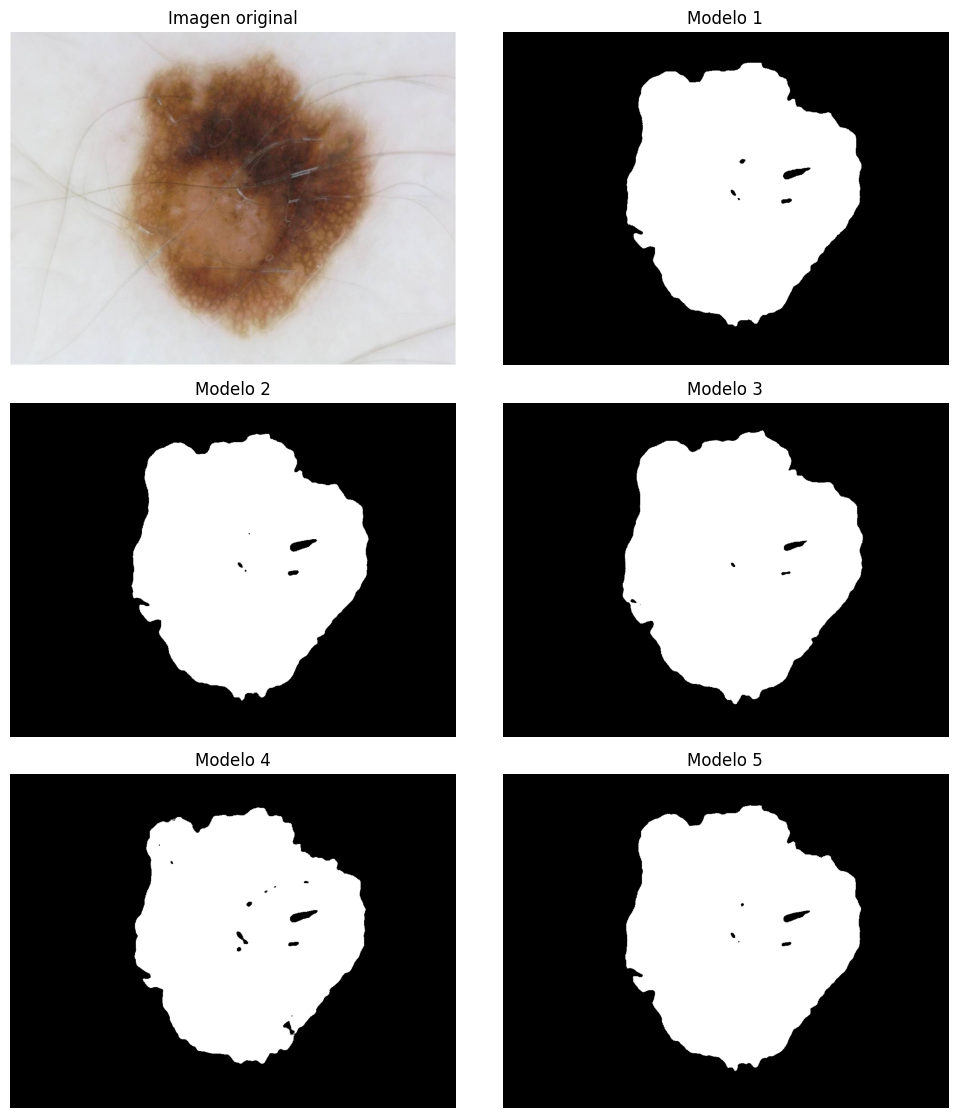

In [99]:
# Ruta a la imagen
img_path = "./DATA-LesionSegmentation/test/ImagesTs/ISIC_0000003.jpg"

# Leer y preparar imagen
image = cv2.imread(img_path)
image = cv2.resize(image, (1024, 768), interpolation=cv2.INTER_LANCZOS4)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_tensor = to_tensor(image_rgb).unsqueeze(0).float().to("cuda" if torch.cuda.is_available() else "cpu")

# Modelos
model_paths = [
    "model_1.pth",
    "model_2.pth",
    "model_3.pth",
    "model_4.pth",
    "model_5.pth"
]

# Iniciar figura
plt.figure(figsize=(10, 15))

# Imagen original
plt.subplot(4, 2, 1)
plt.imshow(image_rgb)
plt.title("Imagen original")
plt.axis("off")

# Evaluar con cada modelo
for i, path in enumerate(model_paths):
    model = SimpleUNet().to(input_tensor.device)
    model.load_state_dict(torch.load(path))
    model.eval()

    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = (output > 0.5).float().squeeze().cpu().numpy()
        # Pasa a máscara binaria

    plt.subplot(4, 2, i + 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title(f"Modelo {i + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Se han utilizado para métricas el IoU y el Dicem, útiles para evaluar qué tan bien se solapan las máscaras predichas por el modelo con las máscaras reales (ground truth).

El IoU se calcula dividiendo el área donde ambas máscaras coinciden (intersección) entre el área total combinada de ambas (unión).

El Dice, también mide el solapamiento, pero da el doble de importancia a la intersección con respecto al total de píxeles positivos.

Además, se obervan que los resultados son óptimos para estimar la incertidumbre resultante.


Once you have trained your ensemble of $N$ models, the next step is to estimate the epistemic uncertainty!

To do this, consider a test input and perform inference using each of the $N$ models independently. This results in a collection of $N$ output predictions for the same input sample. By stacking these predictions, you obtain a vector of $N$ samples for each output variable (e.g., each pixel in an image or each voxel in a volume).

Epistemic uncertainty can then be quantified by measuring the disagreement across these samples. Common statistical measures include variance, standard deviation or entropy.

Once the per-sample uncertainty is computed, it can be interpreted in two main ways:

- **Spatially**: by visualizing the uncertainty on a pixel- or voxel-wise basis, creating an uncertainty map that highlights which regions the model is less confident about.

- **Globally**: by summarizing the uncertainty across the entire prediction; for example, by computing the mean or median value of the uncertainty map. This provides a single scalar metric representing the overall model confidence for that specific prediction.

In [109]:
# 1. Inference of N models
# Para estimar la incertidumbre se infiere sobre la misma imagen pero sin applicarle la máscara binaria final
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Imagen
img_path = './DATA-LesionSegmentation/test/ImagesTs/ISIC_0000003.jpg'
image = cv2.imread(img_path)
image = cv2.resize(image, (1024, 768), interpolation=cv2.INTER_LANCZOS4)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_tensor = to_tensor(image_rgb).unsqueeze(0).float().to(device)  # [1, 3, H, W]

# Modelos
model_paths = [f"model_{i}.pth" for i in range(1, 6)]

# Inferencia con los N modelos
predictions = []

for path in model_paths:
    model = SimpleUNet().to(device)
    model.load_state_dict(torch.load(path))
    model.eval()

    with torch.no_grad():
        output = model(input_tensor)  # [1, 1, H, W]
        predictions.append(output.squeeze().cpu().numpy())  # [H, W]

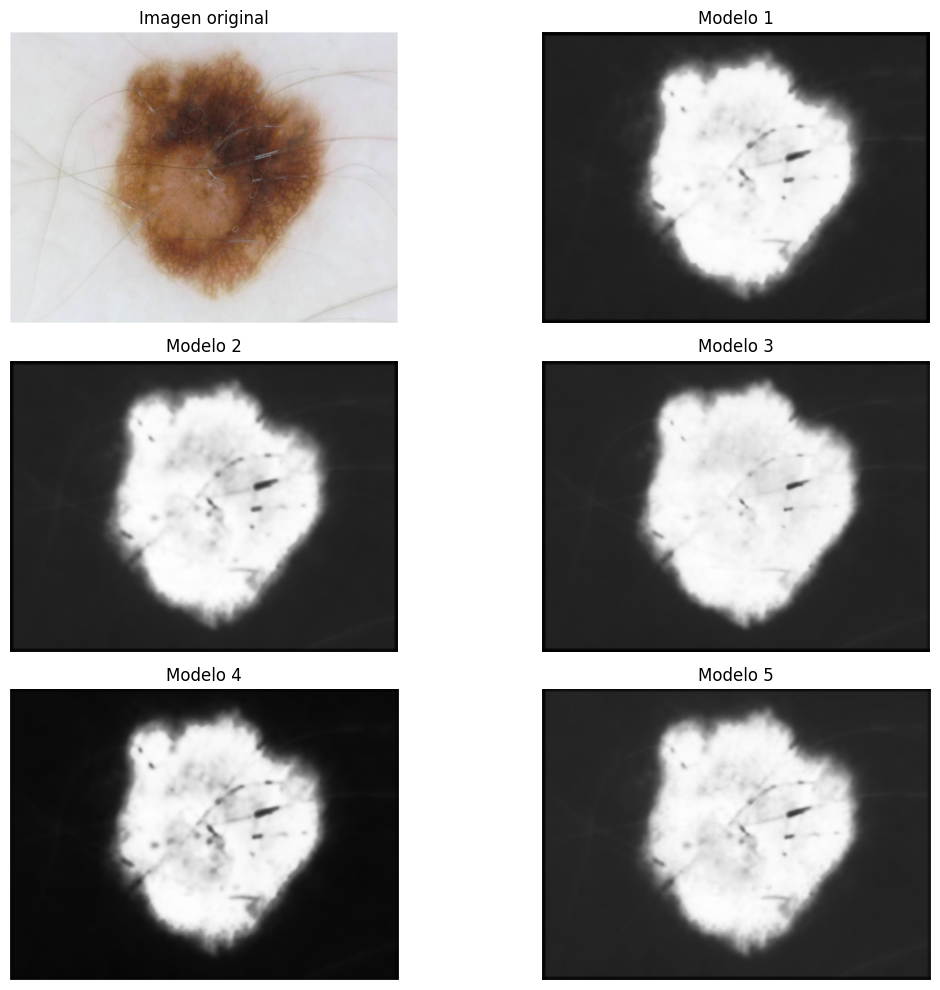

In [110]:
# 2. Visualize N predictions
plt.figure(figsize=(12, 10))

# Imagen original (posición 1 de 6)
plt.subplot(3, 2, 1)
plt.imshow(image_rgb)
plt.title("Imagen original")
plt.axis("off")

# Predicciones de los 5 modelos
for i, pred in enumerate(predictions):
    plt.subplot(3, 2, i + 2)
    plt.imshow(pred, cmap="gray")
    plt.title(f"Modelo {i + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [111]:
# 3. Create a vector of N predictions
# Convertimos lista de 5 predicciones en un array de shape [5, 768, 1024]
pred_array = np.stack(predictions, axis=0)

In [116]:
# 3. Compute Metrics

# Varianza
variance = np.var(pred_array, axis=0)  # [768, 1024]

# Desviación estándar
std_map = np.std(pred_array, axis=0)   # [768, 1024]

print("=== Métricas de incertidumbre en imagen ISIC_0000003 ===")
print(f"  Varianza media         : {variance.mean():.6f}")
print(f"  Varianza máxima        : {variance.max():.6f}")
print(f"  Varianza mínima        : {variance.min():.6f}")
print(f"  Desviación estándar media: {std_map.mean():.6f}")

=== Métricas de incertidumbre en imagen ISIC_0000003 ===
  Varianza media         : 0.000681
  Varianza máxima        : 0.007449
  Varianza mínima        : 0.000012
  Desviación estándar media: 0.023177


Los resultados demuestran que el modelo es estable, si que es cierto que la imagen no es muy compleja, se podría porbar con otras de mayor complejidad.

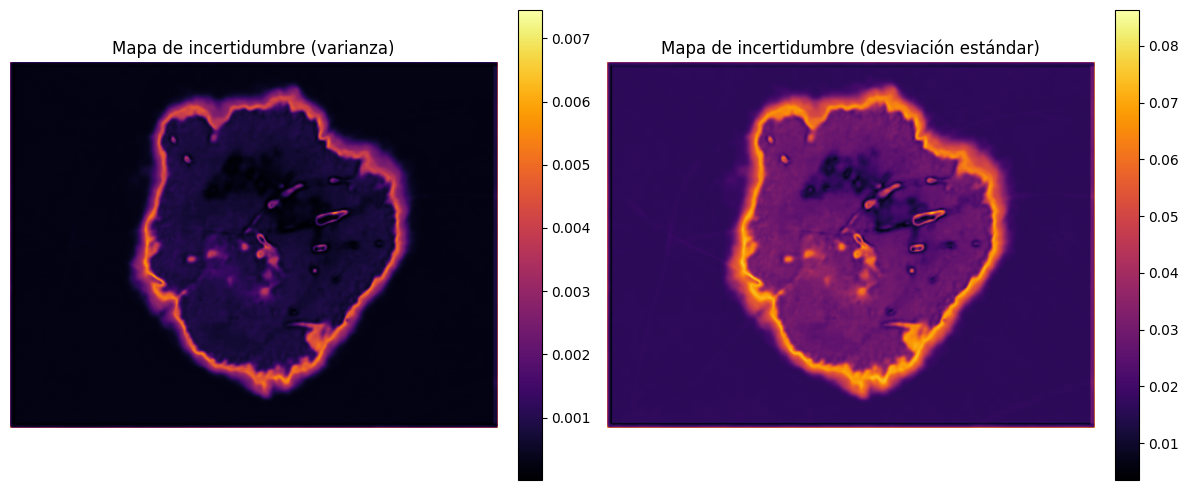

In [117]:
# 4. Visualize Uncertainty maps

plt.figure(figsize=(12, 5))

# Mapa de varianza
plt.subplot(1, 2, 1)
plt.imshow(variance, cmap='inferno')
plt.title("Mapa de incertidumbre (varianza)")
plt.axis("off")
plt.colorbar(fraction=0.046, pad=0.04)

# Mapa de desviación estándar
plt.subplot(1, 2, 2)
plt.imshow(std_map, cmap='inferno')
plt.title("Mapa de incertidumbre (desviación estándar)")
plt.axis("off")
plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

Se observa una mayor varianza y desviación estándar en zonas donde al modelo le cuesta más ponerse de acuerdo. Es decir, zonas conflictivas como bordes de la lesión, zonas ambiguas como pelos o regiones con bajo contraste.

In [119]:
# 5. Provide a global measure for this test sample
global_uncertainty = std_map.mean()
print(f"Incertidumbre global en la imagen: {global_uncertainty:.6f}")

Incertidumbre global en la imagen: 0.023177


#### FAST QUESTIONS ON EPISTEMIC UNCERTAINTY

- **What are the main limitations of deep ensembles?**
- Principalmente que requieren mucho tiempo y recursos computacionales, sin garantizar que se estén aprendiendo características importantes distintas. No presentan diversidad.

- **How do you select the most suitable number of ensembles?**
- El número de modelos que garanticen una incertidumbre óptima sin comprometer excesivamente coste computacional. Considero que con 5–10 modelos puede ser suficiente.

- **Would it be appropiate to remove worst performing ensembles?**
- Sí, es apropiado eliminar modelos con peor rendimiento, ya que mejorar el resultado promedio, pero a la vez, se perdería parte de la diversidad que es fundamental para estimar la incertidumbre.

- **How do deep ensembles improve the reliability of image segmentaton?**
- Mejoran la fiabilidad de las predicciones, ya que permiten señalar qué regiones generan mayor desacuerdo. Esto aumenta la confianza cínica y la interpretabilidad.

- **What other epistemic uncertainty estimation techniques could be considered and how do they compare to ensembles?**
- Además de los deep ensembles, existen otras técnicas como los métodos probabilísticos, como redes bayesianas, que asignan probabilidades a los resultados y están basados en teoría de la probabilidad. También existen métodos no probabilísticos, que estiman la incertidumbre usando reglas o métricas deterministas, sin requerir un modelo probabilístico. Los ensembles son más precisos pero costosos computacionalmente. En cambio, los métodos probabilísticos son más eficientes, aunque a veces menos fiables.
- **Could combining multiple uncertainty metrics provide a more robust or informative uncertainty map?**
- Sí. Unir varianza, entropía o entropía cruzada puede dar una visión más completa del nivel de incertidumbre del modelo en distintas regiones.

## `TASK 2`: Estimating aleatoric uncertainty with TTA

Aleatoric uncertainty captures the uncertainty that arises from inherent noise or ambiguity in the data itself. One of the most relevant techniques to model aleatoric uncertainty is **Test-Time Augmentation (TTA)**, in which several transformations are applied to the input data prior to the inference stage, collecting possible changes and studying the robustness of the model against them. 

To apply TTA, the first step is to define a set of **$K$ random reversible transformations** that can be applied to the input images. Examples include horizontal or vertical flips, small rotations or intensity shifts.

Once the transformations are defined, the next step is to select one of the models from the previous section (you can choose the one with the best performance:)). This model will then be used to perform inference over the $K$ augmented versions of a given test image. Each augmented input is passed through the model independently, resulting in $K$ separate predictions corresponding to each transformation.

Because the model was applied to transformed inputs, the predictions themselves must be mapped back to the original image space by applying the inverse of each transformation. This ensures that all predictions are aligned and comparable on a pixel-wise level. Once restored to their original orientation, these predictions form a set of outputs that reflect the model's response to input variability.

To estimate aleatoric uncertainty, the final step is to compute **disagreement metrics** across the $K$ predictions. You can use the ones defined on the previous section or other you can think of. Just as before, these metrics can be analyzed both visually, by creating uncertainty maps that show pixel-wise uncertainty, and globally, by summarizing the uncertainty values over the entire image These visual and statistical assessments provide valuable insight into where the data itself introduces ambiguity.

In [36]:
import torch
import random
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_tensor

# El modelo 3 es el que ha dado mejores métricas, se utilizará dicho modelo en esta sección.
# 1. Define a function to generate K reversible rotations.
# Aplicamos solo rotaciones
# Definir una función para generar K rotaciones reversibles

# Función para generar K rotaciones y sus inversas
def generate_k_rotations(image, k=5):
    # Ángulos de rotación posibles
    angles = [0, 90, 180, 270]  # Rotaciones posibles (reversibles)

    # Crear una lista para almacenar las imágenes transformadas
    transformed_images = []
    transformations = []  # Lista para almacenar los ángulos de rotación realizados

    # Aplicar k rotaciones aleatorias
    for _ in range(k):
        # Seleccionar una rotación aleatoria
        angle = random.choice(angles)

        # Aplicar la rotación
        rotated_image = torch.rot90(image, k=angle // 90, dims=(2, 3))  # Rotar imagen en 90 grados
        transformed_images.append(rotated_image)
        transformations.append(angle)

    return transformed_images, transformations

# Función para invertir las rotaciones
def invert_rotations(transformed_images, transformations):
    inverted_images = []

    for img, angle in zip(transformed_images, transformations):
        if angle == 90:
            inverted_image = torch.rot90(img, k=3, dims=(2, 3))  # Rotación inversa de 90°
        elif angle == 180:
            inverted_image = torch.rot90(img, k=2, dims=(2, 3))  # Rotación inversa de 180°
        elif angle == 270:
            inverted_image = torch.rot90(img, k=1, dims=(2, 3))  # Rotación inversa de 270°
        else:
            inverted_image = img  # No rotar si el ángulo original fue 0°

        inverted_images.append(inverted_image)

    return inverted_images


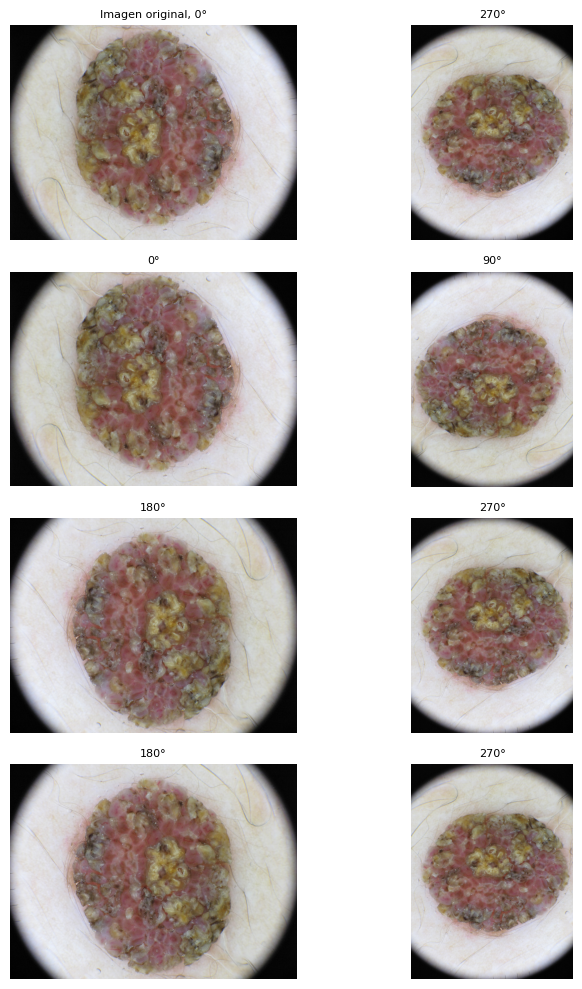

In [60]:
# 2. Select a test case and apply K transformations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Imagen
img_path = './DATA-LesionSegmentation/test/ImagesTs/ISIC_0000101.jpg'

image = cv2.imread(img_path)
image = cv2.resize(image, (1024, 768), interpolation=cv2.INTER_LANCZOS4)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_tensor = to_tensor(image_rgb).unsqueeze(0).float().to(device)  # [1, 3, H, W]

# Aplicar K transformaciones (por ejemplo, 6 transformaciones)
K = 7
transformed_images, transformations = generate_k_rotations(input_tensor, k=K)

# Insertar la original al inicio
all_images       = [input_tensor] + transformed_images
all_transformers = ['Imagen original, 0'] + transformations

fig, axes = plt.subplots(4, 2, figsize=(8, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    # sacamos batch y permutamos a H×W×C
    img   = all_images[i][0].permute(1, 2, 0).cpu().numpy()
    angle = all_transformers[i]
    ax.imshow(img)
    ax.set_title(f"{angle}°", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [73]:
# 3. Perform inference over the K transformed images
# Modelos
model_ = "model_3.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet().to(device)
model.load_state_dict(torch.load(model_, map_location=device))
model.eval()

predictions = []

with torch.no_grad():
    for img in all_images:
        img = img.to(device)
        out = model(img)
        predictions.append(out.squeeze().cpu().numpy())  # [H, W]

print(f"Inferidas {len(predictions)} predicciones de tamaño {predictions[0].shape}")


Inferidas 8 predicciones de tamaño (768, 1024)


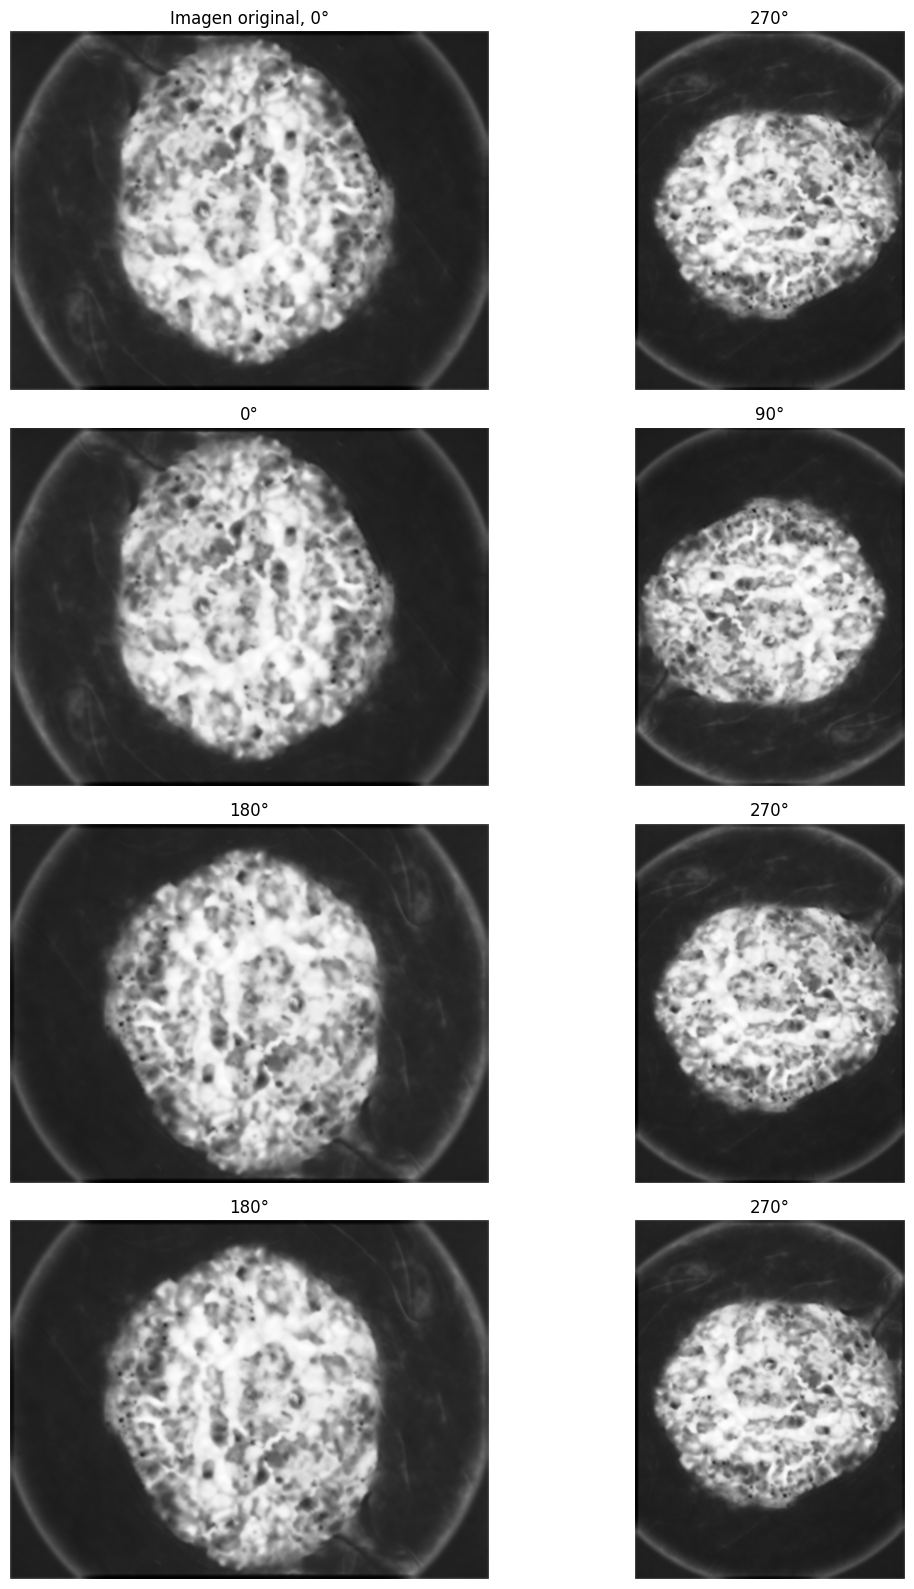

In [74]:
# 4 filas × 2 columnas
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(predictions[i], cmap='gray')          # Mostrar la máscara
    angle = all_transformers[i]
    ax.set_title(f"{angle}°")                       # Título con el ángulo
    ax.axis('off')

plt.tight_layout()
plt.show()

In [76]:
# 4. Apply inverse transformation on the predicted inputs
pred_tensors = []
for p in predictions:
    t = torch.from_numpy(p).unsqueeze(0).unsqueeze(0).to(device)  # [1,1,H,W]
    pred_tensors.append(t)

# Invierte
aligned_tensors = invert_rotations(pred_tensors, all_transformers)


In [ ]:
# 5. Compute a vector of the aligned K predictions
aligned_preds = [ t.squeeze().cpu().numpy() for t in aligned_tensors ]


In [82]:
# 6. Compute Disagreement Metrics
# lista de K tensores
preds = torch.cat(aligned_tensors, dim=0).squeeze(1)  # shape (K, H, W)

# Varianza pixel
var_map = preds.var(dim=0)      # shape (H, W)

# 2) Entropía
eps      = 1e-6
mean_map = preds.mean(dim=0)    # shape (H, W)
entropy_map = -(
    mean_map * torch.log(mean_map + eps) +
    (1 - mean_map) * torch.log(1 - mean_map + eps)
)                               # shape (H, W)

global_var = var_map.mean().item()
global_ent = entropy_map.mean().item()

print(f"Varianza global : {global_var:.4f}")
print(f"Entropía global : {global_ent:.4f}")


Varianza global : 0.0001
Entropía global : 0.4969


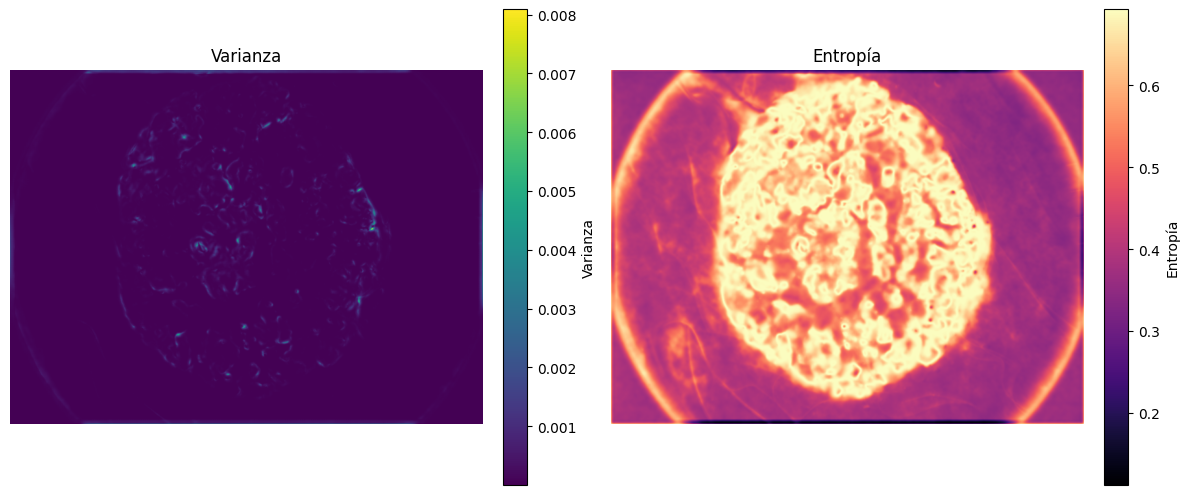

In [83]:
# 7. Visualize Uncertainty maps
var_map     = var_map.cpu().numpy()
entropy_map = entropy_map.cpu().numpy()

# Crear figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#Mapa de varianza
im0 = axes[0].imshow(var_map, cmap='viridis')
axes[0].set_title("Varianza")
axes[0].axis('off')
cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
cbar0.set_label("Varianza")

# Mapa de entropía
im1 = axes[1].imshow(entropy_map, cmap='magma')
axes[1].set_title("Entropía")
axes[1].axis('off')
cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
cbar1.set_label("Entropía")

plt.tight_layout()
plt.show()


El modelo apenas varía dentro de la masa, pero sí muestra algo más de fluctuación en los contornos, donde la información de la imagen es más ambigua. De todas formas, la varianza se mantiene en valores moy bajos.

Sin embargo, la entropía refleja el nivel de seguridad del modelo. En este caso, predominan valores altos de entropía, lo que indica que, aunque la varianza entre predicciones es baja, la probabilidad media se encuentra cerca de 0.5. Es decir, el modelo es consistente, pero en su duda. Esto sugiere que el modelo no tiene suficiente certeza para decidir si esos píxeles pertenecen a fondo o a lesión, y, por tanto, podrían requerir revisión o refinamiento.

In [84]:
# 8. Provide a global measure of alearoric uncertainty for this test sample
global_var = var_map.mean().item()
global_ent = entropy_map.mean().item()

print(f"Global Aleatoric Uncertainty (var): {global_var:.4f}")
print(f"Global Aleatoric Uncertainty (ent): {global_ent:.4f}")

Global Aleatoric Uncertainty (var): 0.0001
Global Aleatoric Uncertainty (ent): 0.4969


#### FAST QUESTIONS ON ALEATORIC UNCERTAINTY

- **What are the main limitations of TTA?**
- Aumenta el tiempo de inferencia y principalmente depende de transformaciones bien elegidas, que pueden no capturar toda la incertidumbre.

- **How do you select the most suitable transformations?**
- Deben ser coherentes con la variabilidad real del problema y reversibles.

- **How would the choice of $K$ (the number of augmentations) affect the quality of the uncertainty estimate?**
- Más K da estimaciones más estables, pero con mayor coste computacional. Muy bajo puede no ser representativo.

- **Can we apply any transformation on our test? What are the restrictions?**
- No, deben ser reversibles y no alterar el contenido semántico. No pueden deformar la anatomía del objeto de interés.

- **What are potential pitfalls of using aggressive augmentations during TTA?**
- Pueden generar artefactos o modificar el significado de la imagen, introduciendo ruido artificial.

- **How can this technique improve the reliability of image segmentaton?**
- Permite identificar regiones dudosas y detectar errores potenciales, ayudando a una interpretación más segura.

- **Could combining TTA with model ensembling give you both epistemic and aleatoric uncertainty? How?**
- Sí. TTA aporta aleatoria y los ensembles aportan epistémica. Combinando ambos se cubren distintas fuentes de incertidumbre.

- **How can global uncertainty measures be useful in a clinical or real-world setting? How would you integrate them?**
- Pueden marcar casos dudosos para revisión, priorizar imágenes críticas o ajustar umbrales de decisión automáticamente.

- **Should UNcertainty QUantification be applied to non-medical tasks? When it is important to consider it?**
- Sí, especialmente en tareas críticas como conducción autónoma, seguridad o decisiones automáticas que afectan a personas. Esto se debe a que pequeñas variaciones, no estudiadas, pueden tener consecuencias muy significativas.